In [1]:
dataset_dir =r"C:/Users/User/Desktop/rakin2/insulator-segmentation/"
csv_file = '/home/rakin/Desktop/segment/artifacts/train_data.csv'  # Update with the actual path
import os 

In [2]:
imag_dir = os.path.join(dataset_dir,'images/polymer')
mask_dir = os.path.join(dataset_dir,'mask/polymer')
print(imag_dir, mask_dir)
print(len(os.listdir(imag_dir)))
print(len(os.listdir(mask_dir)))
assert len(os.listdir(mask_dir)) == len(os.listdir(imag_dir))



C:/Users/User/Desktop/rakin2/insulator-segmentation/images/polymer C:/Users/User/Desktop/rakin2/insulator-segmentation/mask/polymer
15761
15761


In [3]:

images_dir_list = []
mask_dir_list = []
for i in os.listdir(imag_dir): 
    images_dir_list.append(os.path.join(imag_dir,i))
    mask_dir_list.append(os.path.join(mask_dir,i))
    


In [4]:
import pandas as pd 
from PIL.Image import open
from torchmetrics.segmentation import MeanIoU , GeneralizedDiceScore 
from torchmetrics.classification import BinaryAccuracy,BinaryJaccardIndex
from Seg.utils.common import read_yaml
from Seg.utils.logger import logger
from tqdm import tqdm
import matplotlib.pyplot as plt 
import torch
import albumentations as A
import numpy as np
import datetime as dt 
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from  Seg.components.models import  model_list , R2U_Net,AttU_Net
#config = read_yaml(r"Desktop/segment/config/config.yaml")
date_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
logger.info(f"date_time: {date_time}")

# criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.CrossEntropyLoss()
criterion = smp.losses.DiceLoss(mode='binary')
# focal loss
#criterion = smp.losses.FocalLoss(mode='binary',gamma=1.0)
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
BinaryJaccardIndex_Score = BinaryJaccardIndex().to('cuda')

C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


[2025-02-16 23:24:31,071: INFO: 3804955329: date_time: 20250216-232431]


In [5]:
Train_config = {
  "device" : "cuda",
  "batch_size" : 6,
  "epochs" : 20,
  "lr" : 0.001,
  "loss" : "dice_loss" #dice_loss
}

Model_config = {
    "model_name" : "pspnet",
    "backbone" : "resnet50", #resnet34
    "weights" : "imagenet",
    "in_channels" : 3 
}

Transform_config = {
    #train transform config 
   "image_size" : 512, 
   "shift_limit" : 0.2,
   "scale_limit" : 0.2,
   "rotate_limit" : 30,
   "ShiftScaleRotate_p" : 0.5, 
   "r_shift_limit" : 25,
   "g_shift_limit" : 25,
   "b_shift_limit" : 25,
   "RGB_Shift_p" : 0.5,
   "brightness_limit" : 0.3, 
   "contrast_limit" : 0.3,
   "RandomBrightnessContrast_p" : 0.5
}
Data_injection = {
    "seed" : 42, 
    "dataset_dir" : "Desktop/rakin2/segment/artifacts/dataset.csv",
    "train_csv_dir" : "Desktop/rakin2/segment/artifacts/train_data.csv",
    "test_csv_dir" : "Desktop/rakin2/segment/artifacts/test_data.csv",
    "val_csv_dir" : "Desktop/rakin2/segment/artifacts/val_data.csv"
}


In [6]:
train_config=Train_config
model_config=Model_config
transform_config=Transform_config
data_injecton_config =Data_injection
logger.info(f"train_config: {train_config}") 
logger.info(f"model_config: {model_config}")
logger.info(f"transform_config: {transform_config}")
logger.info(f"data_injecton_config: {data_injecton_config}")



[2025-02-16 23:24:31,197: INFO: 342151172: train_config: {'device': 'cuda', 'batch_size': 6, 'epochs': 20, 'lr': 0.001, 'loss': 'dice_loss'}]
[2025-02-16 23:24:31,198: INFO: 342151172: model_config: {'model_name': 'pspnet', 'backbone': 'resnet50', 'weights': 'imagenet', 'in_channels': 3}]
[2025-02-16 23:24:31,198: INFO: 342151172: transform_config: {'image_size': 512, 'shift_limit': 0.2, 'scale_limit': 0.2, 'rotate_limit': 30, 'ShiftScaleRotate_p': 0.5, 'r_shift_limit': 25, 'g_shift_limit': 25, 'b_shift_limit': 25, 'RGB_Shift_p': 0.5, 'brightness_limit': 0.3, 'contrast_limit': 0.3, 'RandomBrightnessContrast_p': 0.5}]
[2025-02-16 23:24:31,199: INFO: 342151172: data_injecton_config: {'seed': 42, 'dataset_dir': 'Desktop/rakin2/segment/artifacts/dataset.csv', 'train_csv_dir': 'Desktop/rakin2/segment/artifacts/train_data.csv', 'test_csv_dir': 'Desktop/rakin2/segment/artifacts/test_data.csv', 'val_csv_dir': 'Desktop/rakin2/segment/artifacts/val_data.csv'}]


(-0.5, 511.5, 511.5, -0.5)

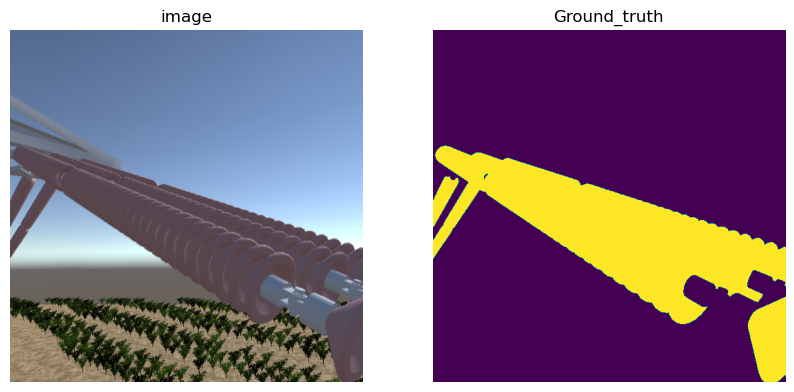

In [7]:


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,8))
ax1.imshow(open(images_dir_list[2]))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(open(mask_dir_list[2]))
ax2.set_title('Ground_truth')
ax2.axis('off')


In [8]:
x=pd.DataFrame({'imag_dir_list': images_dir_list , 'mask_dir_list':mask_dir_list})

In [9]:
x.to_csv('dataset.csv')

In [10]:

from PIL import Image
from torch.utils.data import Dataset



class SegmentDataset(Dataset):
    """
    DroneDataset class for loading the dataset with one-hot encoded masks.

    Args:
        img_path: Path to the images directory.
        mask_path: Path to the masks directory.
        X: List of image names.
        transform: Data augmentation transformations.

    Returns:
        image: Image tensor.
        mask: One-hot encoded mask tensor.
    """

    def __init__(self, csv_path , num_classes=2, transform=None):
        self.dataset = pd.read_csv(csv_path)
        self.img_path = self.dataset['imag_dir_list']
        self.mask_path = self.dataset['mask_dir_list']
        self.num_classes = num_classes  # Number of classes for one-hot encoding
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image and mask
        image = np.array(Image.open(self.img_path[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_path[idx]).convert("L"))  # Grayscale mask

        # Apply Albumentations transformations (if any)
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # One-hot encode the mask
        mask_one_hot = np.zeros((mask.shape[0], mask.shape[1], self.num_classes), dtype=np.float32)
        
        # Create one-hot encoding using the unique values in the mask
        for i, unique_value in enumerate(np.unique(mask)):
            mask_one_hot[:, :, i][mask == unique_value] = 1
        
        # Normalize the image using Albumentations Normalize
        norm = A.Normalize(mean=(0 ,0, 0), std=(1, 1, 1))(image=image, mask=mask_one_hot)
        
        # Return image and one-hot encoded mask as tensors in [C, H, W] format
        return norm["image"].transpose(2, 0, 1), norm["mask"].transpose(2, 0, 1).astype("float32")



In [11]:

class DataInjection():
    def __init__(self , Dataset_dir) -> None:
        self.dataset = pd.read_csv(Dataset_dir)
        #self.injection_config = config["Data_injection"]
        

    def inject(self):
        logger.info('data injection started')
        if 'Unnamed: 0' in self.dataset.columns:
            dataset_cleaned = self.dataset.drop(columns=['Unnamed: 0'])
        else:
            dataset_cleaned = self.dataset

        logger.info('train data spliting ')
        train_data, temp_data = train_test_split(dataset_cleaned, test_size=0.2, random_state=42)
        logger.info('val test spliting ')
        val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

        logger.info('csv saving started')   
        train_data.to_csv('train_data.csv', index=False)
        logger.info('train csv done ')
        val_data.to_csv('val_data.csv', index=False)
        logger.info('val csv done ')
        test_data.to_csv('test_data.csv', index=False)
        logger.info('test csv done')


In [12]:
dInj = DataInjection("C:/Users/User/Desktop/rakin2/segment/notebook/dataset.csv")
dInj.inject()

[2025-02-16 23:24:31,521: INFO: 3993860970: data injection started]
[2025-02-16 23:24:31,522: INFO: 3993860970: train data spliting ]
[2025-02-16 23:24:31,523: INFO: 3993860970: val test spliting ]
[2025-02-16 23:24:31,524: INFO: 3993860970: csv saving started]
[2025-02-16 23:24:31,542: INFO: 3993860970: train csv done ]
[2025-02-16 23:24:31,546: INFO: 3993860970: val csv done ]
[2025-02-16 23:24:31,549: INFO: 3993860970: test csv done]


In [13]:



def model_selection(model_name: str, model_encoder: str, weight: str):
    """
    arg:
      model_name(str) name of the model
      model_encoder(str) : name of the encoder used


    return : model object with given encoder

    """

    model = smp.create_model(
        arch=model_name,  # name of the architecture, e.g. 'Unet'/ 'FPN' / etc. Case INsensitive!
        encoder_name=model_encoder,
        encoder_weights=weight,
        in_channels=3,
        classes=2,
    )

    return model



transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
    ])
   

In [14]:
model = model_selection(Model_config['model_name'], Model_config['backbone'],Model_config['weights'])
model=model.to('cuda')
#model = AttU_Net(3,2).to('cuda')


In [15]:
Train_DL_config = {
    "train_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/train_data.csv",
    "batch_size": 6,
    "num_workers": 4,
    "shuffle": True
}

Val_DL_config = {
    "val_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/val_data.csv",
    "batch_size": 2,
    "num_workers": 4,
    "shuffle": False,
    "transform": True,
    "random_blur": False
}

Test_DL_config = {
    # setting to val as test dir is corrupted in local drive
   "test_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/test_data.csv",
   "batch_size": 2,
   "num_workers": 4,
   "shuffle": False,
   "transform": True
}

In [17]:

train_data = SegmentDataset(Train_DL_config['train_dirs'],2,transform=transform )
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Train_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])
test_data = SegmentDataset(Test_DL_config['test_dirs'],2,transform=transform )
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Test_DL_config['batch_size'], shuffle=Test_DL_config['shuffle'])
val_data = SegmentDataset(Val_DL_config['val_dirs'],2,transform=transform )
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=Val_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'])

mean_iou_score_for_training = []
dice_score_for_training =[]
accuracy_for_training = []
train_loss=[]
binary_jaccard_index_for_training = []
dice_coefficient_for_training = []

mean_iou_score = []
dice_score =[]
accuracy = []
val_loss =[]
binary_jaccard_index = []
dice_coefficient = []

for epoch in range(train_config['epochs']):    
    model.train()
    total_losses = 0
    pbar = tqdm(enumerate(train_dataloader), total = len(train_dataloader),colour='green')
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat,y)
    
        loss.backward()
        optimizer.step()
        total_losses += loss.item()
        jeq_indx_for_training = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou_for_training = IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values_for_training = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc_for_training = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_iou_score_for_training.append(mean_miou_for_training)
        dice_score_for_training.append(dice_score_values_for_training)
        binary_jaccard_index_for_training.append(jeq_indx_for_training)
        dice_coefficient_for_training.append((2*jeq_indx_for_training*1/(1+jeq_indx_for_training)))
        accuracy_for_training.append(acc_for_training)
        train_loss.append(total_losses/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"train_loss": total_losses / (i + 1) , 
                                  "train_Miou_score": sum(mean_iou_score_for_training)/len(mean_iou_score_for_training) ,
                                    "train_dice_score" : sum(dice_score_for_training)/len(dice_score_for_training),
                                   "train_acc": sum(accuracy_for_training)/len(accuracy_for_training),
                                   "train_binary_jaccard_index": sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training),
                                    "train_dice_coefficient": sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)} )

    # mlflow metrics
    #mlflow.log_metric("train_loss", sum(train_loss) / len(train_loss), step=epoch)
    logger.info(f"Epoch: {epoch} | Training_Loss: {total_losses / len(train_dataloader)}")
    # mlflow metrics
    logger.info(f"train_loss {sum(train_loss) / len(train_loss) }")
    logger.info(f"train_Miou_score {sum(mean_iou_score_for_training)/len(mean_iou_score_for_training)}" )
    logger.info(f"train_dice_score {sum(dice_score_for_training)/len(dice_score_for_training)}" )
    logger.info(f"train_acc {sum(accuracy_for_training)/len(accuracy_for_training)}" )
    logger.info(f"train_binary_jaccard_index: {sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training)}")
    logger.info(f"train_dice_coefficient: {sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)}")

    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()
    
    total_loss = 0.0
    model.eval()
 
    pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader),colour="blue")
    
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        y_hat = model(x)
        loss = criterion(y_hat, y)
    
        total_loss += loss.item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        binary_jaccard_index.append(jeq_indx)
        dice_score.append(dice_score_values)
        accuracy.append(acc)
        val_loss.append(total_loss/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"eval_loss": total_loss / (i + 1) , 
                                  "eval_Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                                    "eval_dice_score" : sum(dice_score)/len(dice_score),
                                   "eval_acc": sum(accuracy)/len(accuracy),
                                   "eval_binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                                     "eval_dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)} )
        
        #save model  if val loss is minimum
        
        

    #torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin/segment/artifacts/model_ckpt/unet_{date_time}.pth')
    
    logger.info(f"Epoch: {epoch} | Loss: {total_loss / len(val_dataloader)}")
    # mlflow metrics
    logger.info(f"eval_loss {sum(val_loss) / len(val_loss) }")
    logger.info(f"eval_Miou_score {sum(mean_iou_score)/len(mean_iou_score)}" )
    logger.info(f"eval_dice_score {sum(dice_score)/len(dice_score)}" )
    logger.info(f"eval_acc {sum(accuracy)/len(accuracy)}" )
    logger.info(f"eval_binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    logger.info(f"eval_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    
    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()

100%|██████████| 2102/2102 [04:25<00:00,  7.91it/s, epoch=0, train_loss=0.0351, train_Miou_score=0.414, train_dice_score=0.575, train_acc=0.969, train_binary_jaccard_index=0.777, train_dice_coefficient=0.858] 

[2025-02-16 23:29:41,154: INFO: 2273413975: Epoch: 0 | Training_Loss: 0.035140803663306415]
[2025-02-16 23:29:41,155: INFO: 2273413975: train_loss 0.06031900111858082]
[2025-02-16 23:29:41,155: INFO: 2273413975: train_Miou_score 0.413571701605182]
[2025-02-16 23:29:41,155: INFO: 2273413975: train_dice_score 0.5749413119866762]
[2025-02-16 23:29:41,156: INFO: 2273413975: train_acc 0.9687355988429457]
[2025-02-16 23:29:41,156: INFO: 2273413975: train_binary_jaccard_index: 0.7769934750131982]
[2025-02-16 23:29:41,157: INFO: 2273413975: train_dice_coefficient: 0.8584779817096725]



100%|██████████| 788/788 [00:27<00:00, 28.61it/s, epoch=0, eval_loss=0.0141, eval_Miou_score=0.48, eval_dice_score=0.684, eval_acc=0.986, eval_binary_jaccard_index=0.894, eval_dice_coefficient=0.942] 

[2025-02-16 23:30:08,697: INFO: 2273413975: Epoch: 0 | Loss: 0.014065901413181712]
[2025-02-16 23:30:08,697: INFO: 2273413975: eval_loss 0.013540448860825194]
[2025-02-16 23:30:08,697: INFO: 2273413975: eval_Miou_score 0.47982208295559825]
[2025-02-16 23:30:08,698: INFO: 2273413975: eval_dice_score 0.6840763775830342]
[2025-02-16 23:30:08,698: INFO: 2273413975: eval_acc 0.9862023706968666]
[2025-02-16 23:30:08,698: INFO: 2273413975: eval_binary_jaccard_index: 0.893832873080285]
[2025-02-16 23:30:08,698: INFO: 2273413975: eval_dice_coefficient: 0.9418639763172446]



100%|██████████| 2102/2102 [04:14<00:00,  8.27it/s, epoch=1, train_loss=0.0162, train_Miou_score=0.444, train_dice_score=0.619, train_acc=0.976, train_binary_jaccard_index=0.831, train_dice_coefficient=0.898]

[2025-02-16 23:34:23,014: INFO: 2273413975: Epoch: 1 | Training_Loss: 0.016239565571186998]
[2025-02-16 23:34:23,014: INFO: 2273413975: train_loss 0.038788177827093234]
[2025-02-16 23:34:23,015: INFO: 2273413975: train_Miou_score 0.44358775995601957]
[2025-02-16 23:34:23,015: INFO: 2273413975: train_dice_score 0.619102094539469]
[2025-02-16 23:34:23,016: INFO: 2273413975: train_acc 0.9763578177632659]
[2025-02-16 23:34:23,016: INFO: 2273413975: train_binary_jaccard_index: 0.8310921241095548]
[2025-02-16 23:34:23,016: INFO: 2273413975: train_dice_coefficient: 0.8980555805384415]



100%|██████████| 788/788 [00:26<00:00, 29.90it/s, epoch=1, eval_loss=0.0136, eval_Miou_score=0.482, eval_dice_score=0.689, eval_acc=0.986, eval_binary_jaccard_index=0.895, eval_dice_coefficient=0.942]

[2025-02-16 23:34:49,372: INFO: 2273413975: Epoch: 1 | Loss: 0.013588969477542161]
[2025-02-16 23:34:49,372: INFO: 2273413975: eval_loss 0.013857862526615345]


[2025-02-16 23:34:49,373: INFO: 2273413975: eval_Miou_score 0.4818231519406217]
[2025-02-16 23:34:49,373: INFO: 2273413975: eval_dice_score 0.6887978693886381]
[2025-02-16 23:34:49,373: INFO: 2273413975: eval_acc 0.9863874573392917]
[2025-02-16 23:34:49,374: INFO: 2273413975: eval_binary_jaccard_index: 0.8950885539392227]
[2025-02-16 23:34:49,374: INFO: 2273413975: eval_dice_coefficient: 0.9422428265994526]


100%|██████████| 2102/2102 [04:14<00:00,  8.27it/s, epoch=2, train_loss=0.0147, train_Miou_score=0.455, train_dice_score=0.639, train_acc=0.979, train_binary_jaccard_index=0.852, train_dice_coefficient=0.913]

[2025-02-16 23:39:03,658: INFO: 2273413975: Epoch: 2 | Training_Loss: 0.014743249519567734]
[2025-02-16 23:39:03,659: INFO: 2273413975: train_loss 0.030751931682695608]
[2025-02-16 23:39:03,659: INFO: 2273413975: train_Miou_score 0.45529706580820906]
[2025-02-16 23:39:03,659: INFO: 2273413975: train_dice_score 0.6387169111940162]
[2025-02-16 23:39:03,660: INFO: 2273413975: train_acc 0.9793670815284238]
[2025-02-16 23:39:03,660: INFO: 2273413975: train_binary_jaccard_index: 0.8522210467769551]
[2025-02-16 23:39:03,661: INFO: 2273413975: train_dice_coefficient: 0.9130382943270038]



100%|██████████| 788/788 [00:25<00:00, 30.89it/s, epoch=2, eval_loss=0.0136, eval_Miou_score=0.482, eval_dice_score=0.692, eval_acc=0.986, eval_binary_jaccard_index=0.897, eval_dice_coefficient=0.943]

[2025-02-16 23:39:29,175: INFO: 2273413975: Epoch: 2 | Loss: 0.013582387400157561]
[2025-02-16 23:39:29,176: INFO: 2273413975: eval_loss 0.013924456869394608]
[2025-02-16 23:39:29,176: INFO: 2273413975: eval_Miou_score 0.4819118809112538]
[2025-02-16 23:39:29,176: INFO: 2273413975: eval_dice_score 0.691608197933501]
[2025-02-16 23:39:29,177: INFO: 2273413975: eval_acc 0.9864354488611625]
[2025-02-16 23:39:29,177: INFO: 2273413975: eval_binary_jaccard_index: 0.8965520664179688]
[2025-02-16 23:39:29,178: INFO: 2273413975: eval_dice_coefficient: 0.9431575265690746]



100%|██████████| 2102/2102 [04:13<00:00,  8.29it/s, epoch=3, train_loss=0.0133, train_Miou_score=0.462, train_dice_score=0.651, train_acc=0.981, train_binary_jaccard_index=0.865, train_dice_coefficient=0.922]

[2025-02-16 23:43:42,671: INFO: 2273413975: Epoch: 3 | Training_Loss: 0.013257696955233501]
[2025-02-16 23:43:42,671: INFO: 2273413975: train_loss 0.026344899202068117]
[2025-02-16 23:43:42,671: INFO: 2273413975: train_Miou_score 0.46209039131908397]
[2025-02-16 23:43:42,671: INFO: 2273413975: train_dice_score 0.6508753049234833]
[2025-02-16 23:43:42,672: INFO: 2273413975: train_acc 0.9812309107079492]
[2025-02-16 23:43:42,672: INFO: 2273413975: train_binary_jaccard_index: 0.8650288000623783]
[2025-02-16 23:43:42,672: INFO: 2273413975: train_dice_coefficient: 0.9218740363091646]



100%|██████████| 788/788 [00:25<00:00, 30.93it/s, epoch=3, eval_loss=0.0138, eval_Miou_score=0.483, eval_dice_score=0.693, eval_acc=0.986, eval_binary_jaccard_index=0.897, eval_dice_coefficient=0.943]


[2025-02-16 23:44:08,153: INFO: 2273413975: Epoch: 3 | Loss: 0.013790599661430127]
[2025-02-16 23:44:08,154: INFO: 2273413975: eval_loss 0.01380443879653684]
[2025-02-16 23:44:08,155: INFO: 2273413975: eval_Miou_score 0.48251692820718595]
[2025-02-16 23:44:08,155: INFO: 2273413975: eval_dice_score 0.6925248971804598]
[2025-02-16 23:44:08,155: INFO: 2273413975: eval_acc 0.9863915697572195]
[2025-02-16 23:44:08,156: INFO: 2273413975: eval_binary_jaccard_index: 0.8967460216670698]
[2025-02-16 23:44:08,156: INFO: 2273413975: eval_dice_coefficient: 0.9432067870158083]


100%|██████████| 2102/2102 [04:13<00:00,  8.30it/s, epoch=4, train_loss=0.0124, train_Miou_score=0.467, train_dice_score=0.661, train_acc=0.983, train_binary_jaccard_index=0.874, train_dice_coefficient=0.928]

[2025-02-16 23:48:21,456: INFO: 2273413975: Epoch: 4 | Training_Loss: 0.012448564015832206]
[2025-02-16 23:48:21,456: INFO: 2273413975: train_loss 0.023715016099045822]
[2025-02-16 23:48:21,457: INFO: 2273413975: train_Miou_score 0.46747813844150965]
[2025-02-16 23:48:21,457: INFO: 2273413975: train_dice_score 0.6607059860500699]
[2025-02-16 23:48:21,457: INFO: 2273413975: train_acc 0.9825072300309345]
[2025-02-16 23:48:21,458: INFO: 2273413975: train_binary_jaccard_index: 0.8738660846154909]
[2025-02-16 23:48:21,458: INFO: 2273413975: train_dice_coefficient: 0.9278334402999824]



100%|██████████| 788/788 [00:25<00:00, 30.64it/s, epoch=4, eval_loss=0.0131, eval_Miou_score=0.483, eval_dice_score=0.697, eval_acc=0.987, eval_binary_jaccard_index=0.898, eval_dice_coefficient=0.944]

[2025-02-16 23:48:47,180: INFO: 2273413975: Epoch: 4 | Loss: 0.01305750640213187]
[2025-02-16 23:48:47,180: INFO: 2273413975: eval_loss 0.013684035450935586]
[2025-02-16 23:48:47,181: INFO: 2273413975: eval_Miou_score 0.4830608229044125]
[2025-02-16 23:48:47,181: INFO: 2273413975: eval_dice_score 0.6971127785685552]
[2025-02-16 23:48:47,181: INFO: 2273413975: eval_acc 0.9865132612625355]
[2025-02-16 23:48:47,182: INFO: 2273413975: eval_binary_jaccard_index: 0.8976247066282076]
[2025-02-16 23:48:47,182: INFO: 2273413975: eval_dice_coefficient: 0.9435368090793983]



100%|██████████| 2102/2102 [04:13<00:00,  8.28it/s, epoch=5, train_loss=0.0122, train_Miou_score=0.471, train_dice_score=0.669, train_acc=0.983, train_binary_jaccard_index=0.88, train_dice_coefficient=0.932] 

[2025-02-16 23:53:00,972: INFO: 2273413975: Epoch: 5 | Training_Loss: 0.01216695098282608]
[2025-02-16 23:53:00,973: INFO: 2273413975: train_loss 0.02191043288152575]
[2025-02-16 23:53:00,973: INFO: 2273413975: train_Miou_score 0.47073146580159086]
[2025-02-16 23:53:00,974: INFO: 2273413975: train_dice_score 0.6685191139615783]
[2025-02-16 23:53:00,974: INFO: 2273413975: train_acc 0.9834033946101718]
[2025-02-16 23:53:00,974: INFO: 2273413975: train_binary_jaccard_index: 0.8800483437650689]
[2025-02-16 23:53:00,975: INFO: 2273413975: train_dice_coefficient: 0.9319566447527196]



100%|██████████| 788/788 [00:25<00:00, 30.47it/s, epoch=5, eval_loss=0.0164, eval_Miou_score=0.481, eval_dice_score=0.695, eval_acc=0.986, eval_binary_jaccard_index=0.895, eval_dice_coefficient=0.941]

[2025-02-16 23:53:26,842: INFO: 2273413975: Epoch: 5 | Loss: 0.016407545977437557]
[2025-02-16 23:53:26,842: INFO: 2273413975: eval_loss 0.01415701974818436]
[2025-02-16 23:53:26,842: INFO: 2273413975: eval_Miou_score 0.48093252655710333]
[2025-02-16 23:53:26,843: INFO: 2273413975: eval_dice_score 0.6946358780578198]
[2025-02-16 23:53:26,843: INFO: 2273413975: eval_acc 0.986035683030001]
[2025-02-16 23:53:26,843: INFO: 2273413975: eval_binary_jaccard_index: 0.8947549045571266]
[2025-02-16 23:53:26,844: INFO: 2273413975: eval_dice_coefficient: 0.9414544364012808]



100%|██████████| 2102/2102 [04:13<00:00,  8.29it/s, epoch=6, train_loss=0.0114, train_Miou_score=0.473, train_dice_score=0.675, train_acc=0.984, train_binary_jaccard_index=0.885, train_dice_coefficient=0.935]

[2025-02-16 23:57:40,453: INFO: 2273413975: Epoch: 6 | Training_Loss: 0.01144140349128607]
[2025-02-16 23:57:40,454: INFO: 2273413975: train_loss 0.02044165157555112]
[2025-02-16 23:57:40,454: INFO: 2273413975: train_Miou_score 0.473401110213128]
[2025-02-16 23:57:40,455: INFO: 2273413975: train_dice_score 0.6748665713426281]
[2025-02-16 23:57:40,455: INFO: 2273413975: train_acc 0.9841467388925206]
[2025-02-16 23:57:40,455: INFO: 2273413975: train_binary_jaccard_index: 0.8851208188675099]
[2025-02-16 23:57:40,456: INFO: 2273413975: train_dice_coefficient: 0.935297251838028]



100%|██████████| 788/788 [00:27<00:00, 29.06it/s, epoch=6, eval_loss=0.0112, eval_Miou_score=0.482, eval_dice_score=0.7, eval_acc=0.986, eval_binary_jaccard_index=0.897, eval_dice_coefficient=0.943]   

[2025-02-16 23:58:07,573: INFO: 2273413975: Epoch: 6 | Loss: 0.011244341806711885]
[2025-02-16 23:58:07,573: INFO: 2273413975: eval_loss 0.013703684666605915]
[2025-02-16 23:58:07,574: INFO: 2273413975: eval_Miou_score 0.4822510523397867]
[2025-02-16 23:58:07,574: INFO: 2273413975: eval_dice_score 0.6998578909273877]
[2025-02-16 23:58:07,574: INFO: 2273413975: eval_acc 0.9864309309529947]
[2025-02-16 23:58:07,575: INFO: 2273413975: eval_binary_jaccard_index: 0.8971163655906116]
[2025-02-16 23:58:07,575: INFO: 2273413975: eval_dice_coefficient: 0.9429053144952593]



100%|██████████| 2102/2102 [04:14<00:00,  8.26it/s, epoch=7, train_loss=0.0112, train_Miou_score=0.476, train_dice_score=0.681, train_acc=0.985, train_binary_jaccard_index=0.889, train_dice_coefficient=0.938]

[2025-02-17 00:02:22,148: INFO: 2273413975: Epoch: 7 | Training_Loss: 0.01116106498252767]
[2025-02-17 00:02:22,149: INFO: 2273413975: train_loss 0.019236820484522903]
[2025-02-17 00:02:22,149: INFO: 2273413975: train_Miou_score 0.4759182964706135]
[2025-02-17 00:02:22,149: INFO: 2273413975: train_dice_score 0.6814322538776035]
[2025-02-17 00:02:22,150: INFO: 2273413975: train_acc 0.9847395337877048]
[2025-02-17 00:02:22,150: INFO: 2273413975: train_binary_jaccard_index: 0.8892140331478166]
[2025-02-17 00:02:22,151: INFO: 2273413975: train_dice_coefficient: 0.9379546110983646]



100%|██████████| 788/788 [00:25<00:00, 30.48it/s, epoch=7, eval_loss=0.0109, eval_Miou_score=0.483, eval_dice_score=0.703, eval_acc=0.987, eval_binary_jaccard_index=0.9, eval_dice_coefficient=0.944]  

[2025-02-17 00:02:48,008: INFO: 2273413975: Epoch: 7 | Loss: 0.01094539070189907]
[2025-02-17 00:02:48,008: INFO: 2273413975: eval_loss 0.013295054825085188]
[2025-02-17 00:02:48,009: INFO: 2273413975: eval_Miou_score 0.48316094856134184]
[2025-02-17 00:02:48,009: INFO: 2273413975: eval_dice_score 0.7028036092946847]
[2025-02-17 00:02:48,009: INFO: 2273413975: eval_acc 0.9867647780379668]
[2025-02-17 00:02:48,010: INFO: 2273413975: eval_binary_jaccard_index: 0.899528438360123]
[2025-02-17 00:02:48,010: INFO: 2273413975: eval_dice_coefficient: 0.9444336941487457]



100%|██████████| 2102/2102 [04:15<00:00,  8.22it/s, epoch=8, train_loss=0.00975, train_Miou_score=0.478, train_dice_score=0.688, train_acc=0.985, train_binary_jaccard_index=0.893, train_dice_coefficient=0.941]

[2025-02-17 00:07:03,587: INFO: 2273413975: Epoch: 8 | Training_Loss: 0.009753283804422554]
[2025-02-17 00:07:03,587: INFO: 2273413975: train_loss 0.018195326499149383]
[2025-02-17 00:07:03,587: INFO: 2273413975: train_Miou_score 0.47831029244819045]
[2025-02-17 00:07:03,588: INFO: 2273413975: train_dice_score 0.6877086933687095]
[2025-02-17 00:07:03,588: INFO: 2273413975: train_acc 0.9853580573236782]
[2025-02-17 00:07:03,589: INFO: 2273413975: train_binary_jaccard_index: 0.8934063246693533]
[2025-02-17 00:07:03,589: INFO: 2273413975: train_dice_coefficient: 0.9405944540672723]



100%|██████████| 788/788 [00:25<00:00, 30.41it/s, epoch=8, eval_loss=0.0125, eval_Miou_score=0.483, eval_dice_score=0.705, eval_acc=0.987, eval_binary_jaccard_index=0.9, eval_dice_coefficient=0.945]

[2025-02-17 00:07:29,501: INFO: 2273413975: Epoch: 8 | Loss: 0.012463576826952436]
[2025-02-17 00:07:29,501: INFO: 2273413975: eval_loss 0.013212827512843407]
[2025-02-17 00:07:29,502: INFO: 2273413975: eval_Miou_score 0.48342236413687584]
[2025-02-17 00:07:29,502: INFO: 2273413975: eval_dice_score 0.7045064231667542]
[2025-02-17 00:07:29,502: INFO: 2273413975: eval_acc 0.9868604551918817]
[2025-02-17 00:07:29,503: INFO: 2273413975: eval_binary_jaccard_index: 0.9002531143803585]
[2025-02-17 00:07:29,503: INFO: 2273413975: eval_dice_coefficient: 0.9448523678256341]



100%|██████████| 2102/2102 [04:14<00:00,  8.24it/s, epoch=9, train_loss=0.00952, train_Miou_score=0.48, train_dice_score=0.693, train_acc=0.986, train_binary_jaccard_index=0.897, train_dice_coefficient=0.943]

[2025-02-17 00:11:44,488: INFO: 2273413975: Epoch: 9 | Training_Loss: 0.00951848766783325]
[2025-02-17 00:11:44,488: INFO: 2273413975: train_loss 0.017374457701272748]
[2025-02-17 00:11:44,489: INFO: 2273413975: train_Miou_score 0.48037988954704725]
[2025-02-17 00:11:44,489: INFO: 2273413975: train_dice_score 0.6931392946254689]
[2025-02-17 00:11:44,489: INFO: 2273413975: train_acc 0.9858783087369717]
[2025-02-17 00:11:44,490: INFO: 2273413975: train_binary_jaccard_index: 0.8970095705012968]
[2025-02-17 00:11:44,490: INFO: 2273413975: train_dice_coefficient: 0.9428268297490304]



100%|██████████| 788/788 [00:26<00:00, 29.71it/s, epoch=9, eval_loss=0.00861, eval_Miou_score=0.485, eval_dice_score=0.71, eval_acc=0.987, eval_binary_jaccard_index=0.903, eval_dice_coefficient=0.947] 

[2025-02-17 00:12:11,012: INFO: 2273413975: Epoch: 9 | Loss: 0.008605787823648016]
[2025-02-17 00:12:11,012: INFO: 2273413975: eval_loss 0.012737558853505186]
[2025-02-17 00:12:11,012: INFO: 2273413975: eval_Miou_score 0.4852305810385458]
[2025-02-17 00:12:11,013: INFO: 2273413975: eval_dice_score 0.7100162032112254]
[2025-02-17 00:12:11,013: INFO: 2273413975: eval_acc 0.9873227729410085]


[2025-02-17 00:12:11,013: INFO: 2273413975: eval_binary_jaccard_index: 0.90327595781516]
[2025-02-17 00:12:11,014: INFO: 2273413975: eval_dice_coefficient: 0.9466690713357092]


100%|██████████| 2102/2102 [04:15<00:00,  8.24it/s, epoch=10, train_loss=0.00852, train_Miou_score=0.483, train_dice_score=0.7, train_acc=0.986, train_binary_jaccard_index=0.901, train_dice_coefficient=0.945]  

[2025-02-17 00:16:26,154: INFO: 2273413975: Epoch: 10 | Training_Loss: 0.008523273054017667]
[2025-02-17 00:16:26,154: INFO: 2273413975: train_loss 0.016553925486933713]
[2025-02-17 00:16:26,155: INFO: 2273413975: train_Miou_score 0.4828246760761358]
[2025-02-17 00:16:26,155: INFO: 2273413975: train_dice_score 0.6995081430211191]
[2025-02-17 00:16:26,156: INFO: 2273413975: train_acc 0.9863956831192622]
[2025-02-17 00:16:26,156: INFO: 2273413975: train_binary_jaccard_index: 0.9006410818434798]
[2025-02-17 00:16:26,157: INFO: 2273413975: train_dice_coefficient: 0.9450233864041998]



100%|██████████| 788/788 [00:26<00:00, 29.74it/s, epoch=10, eval_loss=0.0074, eval_Miou_score=0.487, eval_dice_score=0.716, eval_acc=0.988, eval_binary_jaccard_index=0.907, eval_dice_coefficient=0.949] 

[2025-02-17 00:16:52,657: INFO: 2273413975: Epoch: 10 | Loss: 0.007395969202675795]
[2025-02-17 00:16:52,658: INFO: 2273413975: eval_loss 0.012241385285931572]
[2025-02-17 00:16:52,658: INFO: 2273413975: eval_Miou_score 0.48746041922167277]
[2025-02-17 00:16:52,658: INFO: 2273413975: eval_dice_score 0.7160138253167198]
[2025-02-17 00:16:52,659: INFO: 2273413975: eval_acc 0.9878129642241883]
[2025-02-17 00:16:52,659: INFO: 2273413975: eval_binary_jaccard_index: 0.9067273671138407]
[2025-02-17 00:16:52,660: INFO: 2273413975: eval_dice_coefficient: 0.9487114036068176]



100%|██████████| 2102/2102 [04:14<00:00,  8.25it/s, epoch=11, train_loss=0.00798, train_Miou_score=0.485, train_dice_score=0.706, train_acc=0.987, train_binary_jaccard_index=0.904, train_dice_coefficient=0.947]

[2025-02-17 00:21:07,488: INFO: 2273413975: Epoch: 11 | Training_Loss: 0.00798432677842457]
[2025-02-17 00:21:07,488: INFO: 2273413975: train_loss 0.015815546902839987]
[2025-02-17 00:21:07,489: INFO: 2273413975: train_Miou_score 0.48498507257832335]
[2025-02-17 00:21:07,489: INFO: 2273413975: train_dice_score 0.7055258093612267]
[2025-02-17 00:21:07,490: INFO: 2273413975: train_acc 0.9868712736558922]
[2025-02-17 00:21:07,490: INFO: 2273413975: train_binary_jaccard_index: 0.9039647780665617]
[2025-02-17 00:21:07,490: INFO: 2273413975: train_dice_coefficient: 0.9470214495509856]



100%|██████████| 788/788 [00:26<00:00, 30.25it/s, epoch=11, eval_loss=0.015, eval_Miou_score=0.489, eval_dice_score=0.719, eval_acc=0.988, eval_binary_jaccard_index=0.907, eval_dice_coefficient=0.949] 

[2025-02-17 00:21:33,543: INFO: 2273413975: Epoch: 11 | Loss: 0.014974693205150855]
[2025-02-17 00:21:33,544: INFO: 2273413975: eval_loss 0.012534549799581534]
[2025-02-17 00:21:33,544: INFO: 2273413975: eval_Miou_score 0.488983629358638]
[2025-02-17 00:21:33,544: INFO: 2273413975: eval_dice_score 0.7185491987034403]
[2025-02-17 00:21:33,545: INFO: 2273413975: eval_acc 0.9875866672916057]
[2025-02-17 00:21:33,545: INFO: 2273413975: eval_binary_jaccard_index: 0.9070440149959019]
[2025-02-17 00:21:33,545: INFO: 2273413975: eval_dice_coefficient: 0.9486687377841944]



100%|██████████| 2102/2102 [04:15<00:00,  8.24it/s, epoch=12, train_loss=0.00765, train_Miou_score=0.487, train_dice_score=0.711, train_acc=0.987, train_binary_jaccard_index=0.907, train_dice_coefficient=0.949]

[2025-02-17 00:25:48,667: INFO: 2273413975: Epoch: 12 | Training_Loss: 0.007650550408776208]
[2025-02-17 00:25:48,668: INFO: 2273413975: train_loss 0.01518300505040844]
[2025-02-17 00:25:48,668: INFO: 2273413975: train_Miou_score 0.48700011713495756]
[2025-02-17 00:25:48,669: INFO: 2273413975: train_dice_score 0.7109908402593903]
[2025-02-17 00:25:48,669: INFO: 2273413975: train_acc 0.9872987812786721]
[2025-02-17 00:25:48,669: INFO: 2273413975: train_binary_jaccard_index: 0.9069622892230872]
[2025-02-17 00:25:48,670: INFO: 2273413975: train_dice_coefficient: 0.9488134156094956]



100%|██████████| 788/788 [00:26<00:00, 30.30it/s, epoch=12, eval_loss=0.00773, eval_Miou_score=0.49, eval_dice_score=0.723, eval_acc=0.988, eval_binary_jaccard_index=0.909, eval_dice_coefficient=0.95]  

[2025-02-17 00:26:14,680: INFO: 2273413975: Epoch: 12 | Loss: 0.0077346774375983305]
[2025-02-17 00:26:14,680: INFO: 2273413975: eval_loss 0.012176053816791176]
[2025-02-17 00:26:14,681: INFO: 2273413975: eval_Miou_score 0.49037837558426645]
[2025-02-17 00:26:14,681: INFO: 2273413975: eval_dice_score 0.7229872427390499]
[2025-02-17 00:26:14,682: INFO: 2273413975: eval_acc 0.9879525230062143]
[2025-02-17 00:26:14,682: INFO: 2273413975: eval_binary_jaccard_index: 0.9093278398339472]
[2025-02-17 00:26:14,682: INFO: 2273413975: eval_dice_coefficient: 0.9500290097484435]



100%|██████████| 2102/2102 [04:16<00:00,  8.21it/s, epoch=13, train_loss=0.00747, train_Miou_score=0.489, train_dice_score=0.716, train_acc=0.988, train_binary_jaccard_index=0.91, train_dice_coefficient=0.95] 

[2025-02-17 00:30:30,712: INFO: 2273413975: Epoch: 13 | Training_Loss: 0.0074663137278026]
[2025-02-17 00:30:30,713: INFO: 2273413975: train_loss 0.014645131131741103]
[2025-02-17 00:30:30,713: INFO: 2273413975: train_Miou_score 0.48874785812243426]
[2025-02-17 00:30:30,714: INFO: 2273413975: train_dice_score 0.7157117158565063]
[2025-02-17 00:30:30,715: INFO: 2273413975: train_acc 0.9876780132386482]
[2025-02-17 00:30:30,715: INFO: 2273413975: train_binary_jaccard_index: 0.9095958591773095]
[2025-02-17 00:30:30,715: INFO: 2273413975: train_dice_coefficient: 0.9503863170804957]



100%|██████████| 788/788 [00:27<00:00, 29.16it/s, epoch=13, eval_loss=0.00801, eval_Miou_score=0.492, eval_dice_score=0.728, eval_acc=0.988, eval_binary_jaccard_index=0.912, eval_dice_coefficient=0.951]

[2025-02-17 00:30:57,744: INFO: 2273413975: Epoch: 13 | Loss: 0.008008745040385252]
[2025-02-17 00:30:57,745: INFO: 2273413975: eval_loss 0.011948507538801416]
[2025-02-17 00:30:57,745: INFO: 2273413975: eval_Miou_score 0.49218154773422346]
[2025-02-17 00:30:57,746: INFO: 2273413975: eval_dice_score 0.7279800194956477]
[2025-02-17 00:30:57,746: INFO: 2273413975: eval_acc 0.9882464308596937]
[2025-02-17 00:30:57,746: INFO: 2273413975: eval_binary_jaccard_index: 0.9115251855191284]
[2025-02-17 00:30:57,747: INFO: 2273413975: eval_dice_coefficient: 0.9512724820930036]



100%|██████████| 2102/2102 [04:16<00:00,  8.21it/s, epoch=14, train_loss=0.00748, train_Miou_score=0.49, train_dice_score=0.72, train_acc=0.988, train_binary_jaccard_index=0.912, train_dice_coefficient=0.952]  

[2025-02-17 00:35:13,895: INFO: 2273413975: Epoch: 14 | Training_Loss: 0.007476708811878818]
[2025-02-17 00:35:13,895: INFO: 2273413975: train_loss 0.014158437717483796]
[2025-02-17 00:35:13,895: INFO: 2273413975: train_Miou_score 0.4901225649061064]
[2025-02-17 00:35:13,896: INFO: 2273413975: train_dice_score 0.7201529955256794]
[2025-02-17 00:35:13,896: INFO: 2273413975: train_acc 0.9880058473758837]
[2025-02-17 00:35:13,897: INFO: 2273413975: train_binary_jaccard_index: 0.9118961108307149]
[2025-02-17 00:35:13,897: INFO: 2273413975: train_dice_coefficient: 0.9517522635571645]



100%|██████████| 788/788 [00:27<00:00, 29.13it/s, epoch=14, eval_loss=0.00804, eval_Miou_score=0.494, eval_dice_score=0.732, eval_acc=0.988, eval_binary_jaccard_index=0.913, eval_dice_coefficient=0.952]

[2025-02-17 00:35:40,947: INFO: 2273413975: Epoch: 14 | Loss: 0.00804128199059346]
[2025-02-17 00:35:40,947: INFO: 2273413975: eval_loss 0.011639609961393104]
[2025-02-17 00:35:40,948: INFO: 2273413975: eval_Miou_score 0.4936548604500616]
[2025-02-17 00:35:40,948: INFO: 2273413975: eval_dice_score 0.7324960941180866]
[2025-02-17 00:35:40,948: INFO: 2273413975: eval_acc 0.9884982426961263]
[2025-02-17 00:35:40,949: INFO: 2273413975: eval_binary_jaccard_index: 0.9134039744268315]
[2025-02-17 00:35:40,949: INFO: 2273413975: eval_dice_coefficient: 0.9523521286366214]



100%|██████████| 2102/2102 [04:15<00:00,  8.22it/s, epoch=15, train_loss=0.00688, train_Miou_score=0.492, train_dice_score=0.724, train_acc=0.988, train_binary_jaccard_index=0.914, train_dice_coefficient=0.953]

[2025-02-17 00:39:56,704: INFO: 2273413975: Epoch: 15 | Training_Loss: 0.006877716896536235]
[2025-02-17 00:39:56,705: INFO: 2273413975: train_loss 0.013704787297066364]
[2025-02-17 00:39:56,705: INFO: 2273413975: train_Miou_score 0.4916283416348327]
[2025-02-17 00:39:56,706: INFO: 2273413975: train_dice_score 0.7244130517957463]
[2025-02-17 00:39:56,706: INFO: 2273413975: train_acc 0.9883299528751398]
[2025-02-17 00:39:56,707: INFO: 2273413975: train_binary_jaccard_index: 0.9141434922720165]
[2025-02-17 00:39:56,707: INFO: 2273413975: train_dice_coefficient: 0.9530805656417812]



100%|██████████| 788/788 [00:27<00:00, 29.16it/s, epoch=15, eval_loss=0.007, eval_Miou_score=0.495, eval_dice_score=0.736, eval_acc=0.989, eval_binary_jaccard_index=0.915, eval_dice_coefficient=0.954]  

[2025-02-17 00:40:23,731: INFO: 2273413975: Epoch: 15 | Loss: 0.007002714775540502]
[2025-02-17 00:40:23,731: INFO: 2273413975: eval_loss 0.011353619741949343]


[2025-02-17 00:40:23,732: INFO: 2273413975: eval_Miou_score 0.4949758579464818]
[2025-02-17 00:40:23,732: INFO: 2273413975: eval_dice_score 0.7360376425206776]
[2025-02-17 00:40:23,733: INFO: 2273413975: eval_acc 0.988783949220241]
[2025-02-17 00:40:23,733: INFO: 2273413975: eval_binary_jaccard_index: 0.9153400618207126]
[2025-02-17 00:40:23,734: INFO: 2273413975: eval_dice_coefficient: 0.9535087084597624]


100%|██████████| 2102/2102 [04:16<00:00,  8.19it/s, epoch=16, train_loss=0.00703, train_Miou_score=0.493, train_dice_score=0.728, train_acc=0.989, train_binary_jaccard_index=0.916, train_dice_coefficient=0.954]

[2025-02-17 00:44:40,239: INFO: 2273413975: Epoch: 16 | Training_Loss: 0.007030647499690614]
[2025-02-17 00:44:40,240: INFO: 2273413975: train_loss 0.013296132968580598]
[2025-02-17 00:44:40,240: INFO: 2273413975: train_Miou_score 0.4929357219803821]
[2025-02-17 00:44:40,241: INFO: 2273413975: train_dice_score 0.7282286691599965]
[2025-02-17 00:44:40,241: INFO: 2273413975: train_acc 0.9886065992730155]
[2025-02-17 00:44:40,242: INFO: 2273413975: train_binary_jaccard_index: 0.9160799058556479]
[2025-02-17 00:44:40,242: INFO: 2273413975: train_dice_coefficient: 0.9542252778084304]



100%|██████████| 788/788 [00:26<00:00, 29.93it/s, epoch=16, eval_loss=0.0089, eval_Miou_score=0.496, eval_dice_score=0.739, eval_acc=0.989, eval_binary_jaccard_index=0.917, eval_dice_coefficient=0.954] 

[2025-02-17 00:45:06,576: INFO: 2273413975: Epoch: 16 | Loss: 0.00889670160518685]
[2025-02-17 00:45:06,576: INFO: 2273413975: eval_loss 0.01118117664524461]
[2025-02-17 00:45:06,577: INFO: 2273413975: eval_Miou_score 0.4963397661683603]
[2025-02-17 00:45:06,577: INFO: 2273413975: eval_dice_score 0.7393854374466957]
[2025-02-17 00:45:06,577: INFO: 2273413975: eval_acc 0.9889242403469501]
[2025-02-17 00:45:06,578: INFO: 2273413975: eval_binary_jaccard_index: 0.9165929756715457]
[2025-02-17 00:45:06,578: INFO: 2273413975: eval_dice_coefficient: 0.9541426615569069]



100%|██████████| 2102/2102 [04:16<00:00,  8.18it/s, epoch=17, train_loss=0.00676, train_Miou_score=0.494, train_dice_score=0.732, train_acc=0.989, train_binary_jaccard_index=0.918, train_dice_coefficient=0.955]

[2025-02-17 00:49:23,542: INFO: 2273413975: Epoch: 17 | Training_Loss: 0.006755149387156362]
[2025-02-17 00:49:23,542: INFO: 2273413975: train_loss 0.012933736910650202]
[2025-02-17 00:49:23,543: INFO: 2273413975: train_Miou_score 0.49406208068453106]
[2025-02-17 00:49:23,543: INFO: 2273413975: train_dice_score 0.7317363260511095]


[2025-02-17 00:49:23,544: INFO: 2273413975: train_acc 0.9888675744412049]
[2025-02-17 00:49:23,544: INFO: 2273413975: train_binary_jaccard_index: 0.9179043994497298]
[2025-02-17 00:49:23,545: INFO: 2273413975: train_dice_coefficient: 0.9552982124239293]


100%|██████████| 788/788 [00:26<00:00, 29.69it/s, epoch=17, eval_loss=0.00784, eval_Miou_score=0.497, eval_dice_score=0.742, eval_acc=0.989, eval_binary_jaccard_index=0.918, eval_dice_coefficient=0.955]

[2025-02-17 00:49:50,090: INFO: 2273413975: Epoch: 17 | Loss: 0.007840216538022617]


[2025-02-17 00:49:50,091: INFO: 2273413975: eval_loss 0.01098617207249887]
[2025-02-17 00:49:50,091: INFO: 2273413975: eval_Miou_score 0.4974369278425207]
[2025-02-17 00:49:50,091: INFO: 2273413975: eval_dice_score 0.7421639357187607]
[2025-02-17 00:49:50,092: INFO: 2273413975: eval_acc 0.9891075013521629]
[2025-02-17 00:49:50,092: INFO: 2273413975: eval_binary_jaccard_index: 0.917852981509541]
[2025-02-17 00:49:50,093: INFO: 2273413975: eval_dice_coefficient: 0.9548559673982344]


100%|██████████| 2102/2102 [04:17<00:00,  8.18it/s, epoch=18, train_loss=0.00689, train_Miou_score=0.495, train_dice_score=0.735, train_acc=0.989, train_binary_jaccard_index=0.919, train_dice_coefficient=0.956]

[2025-02-17 00:54:07,162: INFO: 2273413975: Epoch: 18 | Training_Loss: 0.006894127257544012]
[2025-02-17 00:54:07,162: INFO: 2273413975: train_loss 0.012618351753220756]
[2025-02-17 00:54:07,163: INFO: 2273413975: train_Miou_score 0.4951268413785077]
[2025-02-17 00:54:07,164: INFO: 2273413975: train_dice_score 0.7348854973324701]
[2025-02-17 00:54:07,164: INFO: 2273413975: train_acc 0.9890935463539152]
[2025-02-17 00:54:07,165: INFO: 2273413975: train_binary_jaccard_index: 0.9194932580159629]
[2025-02-17 00:54:07,165: INFO: 2273413975: train_dice_coefficient: 0.9562359945197481]



100%|██████████| 788/788 [00:27<00:00, 28.56it/s, epoch=18, eval_loss=0.00771, eval_Miou_score=0.498, eval_dice_score=0.745, eval_acc=0.989, eval_binary_jaccard_index=0.919, eval_dice_coefficient=0.956]

[2025-02-17 00:54:34,762: INFO: 2273413975: Epoch: 18 | Loss: 0.0077125983038529525]
[2025-02-17 00:54:34,763: INFO: 2273413975: eval_loss 0.010822038390406562]
[2025-02-17 00:54:34,763: INFO: 2273413975: eval_Miou_score 0.49815320934974633]


[2025-02-17 00:54:34,764: INFO: 2273413975: eval_dice_score 0.7449178266513884]
[2025-02-17 00:54:34,764: INFO: 2273413975: eval_acc 0.9892776206697081]
[2025-02-17 00:54:34,764: INFO: 2273413975: eval_binary_jaccard_index: 0.9190413268236232]
[2025-02-17 00:54:34,765: INFO: 2273413975: eval_dice_coefficient: 0.9555316635457806]


100%|██████████| 2102/2102 [04:17<00:00,  8.17it/s, epoch=19, train_loss=0.00697, train_Miou_score=0.496, train_dice_score=0.738, train_acc=0.989, train_binary_jaccard_index=0.921, train_dice_coefficient=0.957]

[2025-02-17 00:58:52,135: INFO: 2273413975: Epoch: 19 | Training_Loss: 0.006974125679734771]
[2025-02-17 00:58:52,136: INFO: 2273413975: train_loss 0.012318622728114086]
[2025-02-17 00:58:52,136: INFO: 2273413975: train_Miou_score 0.4961117452524195]
[2025-02-17 00:58:52,137: INFO: 2273413975: train_dice_score 0.7376508002796734]
[2025-02-17 00:58:52,137: INFO: 2273413975: train_acc 0.9892928545583893]
[2025-02-17 00:58:52,138: INFO: 2273413975: train_binary_jaccard_index: 0.9208895727504112]
[2025-02-17 00:58:52,138: INFO: 2273413975: train_dice_coefficient: 0.9570605897273817]



100%|██████████| 788/788 [00:27<00:00, 28.79it/s, epoch=19, eval_loss=0.0064, eval_Miou_score=0.499, eval_dice_score=0.748, eval_acc=0.989, eval_binary_jaccard_index=0.92, eval_dice_coefficient=0.956]  

[2025-02-17 00:59:19,509: INFO: 2273413975: Epoch: 19 | Loss: 0.006402296917087535]
[2025-02-17 00:59:19,510: INFO: 2273413975: eval_loss 0.010594176979653659]
[2025-02-17 00:59:19,510: INFO: 2273413975: eval_Miou_score 0.49908732411434353]
[2025-02-17 00:59:19,511: INFO: 2273413975: eval_dice_score 0.7479994934066374]
[2025-02-17 00:59:19,511: INFO: 2273413975: eval_acc 0.9894964984225743]
[2025-02-17 00:59:19,511: INFO: 2273413975: eval_binary_jaccard_index: 0.9204853105715708]
[2025-02-17 00:59:19,512: INFO: 2273413975: eval_dice_coefficient: 0.9563831071780925]


In [19]:
model.eval()
total_loss = 0.0
jc_score=0.0

pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
mean_iou_score = []
dice_score =[]
accuracy = []
binary_jaccard_index = []
dice_coefficient = []

with torch.no_grad():
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')

        y_hat = model(x)
        loss = criterion(y_hat, y)
        total_loss += loss.item()
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)     
        dice_score.append(dice_score_values)
        binary_jaccard_index.append(jeq_indx)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        accuracy.append(acc)
        pbar.set_postfix({"loss": total_loss / (i + 1) , 
                        "Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                        "dice_score" : sum(dice_score)/len(dice_score), 
                        "acc": sum(accuracy)/len(accuracy),
                        "binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                         "dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)})
    
    logger.info(f"Test Loss: {total_loss / len(test_dataloader)}") 
    logger.info(f"Test Miou_score: {sum(mean_iou_score)/len(mean_iou_score)}")
    logger.info(f"Test dice_score: {sum(dice_score)/len(dice_score)}")
    logger.info(f"Test acc: {sum(accuracy)/len(accuracy)}")
    logger.info(f"test_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    logger.info(f"Test binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    #mlflow.log_metric("Test_loss", total_loss / len(test_dataloader))
    #mlflow.log_metric("Test_Miou_score", sum(mean_iou_score)/len(mean_iou_score))
    #mlflow.log_metric("Test_dice_score", sum(dice_score)/len(dice_score))
    #mlflow.log_metric("Test_acc", sum(accuracy)/len(accuracy))
    
    print('----------------------------------') 
    pbar.close()
  


100%|██████████| 789/789 [00:28<00:00, 27.71it/s, loss=0.00652, Miou_score=0.526, dice_score=0.804, acc=0.994, binary_jaccard_index=0.948, dice_coefficient=0.973]

[2025-02-17 00:59:48,011: INFO: 580206084: Test Loss: 0.0065224060389781026]
[2025-02-17 00:59:48,011: INFO: 580206084: Test Miou_score: 0.5261303981806238]
[2025-02-17 00:59:48,011: INFO: 580206084: Test dice_score: 0.803553454058554]
[2025-02-17 00:59:48,012: INFO: 580206084: Test acc: 0.9935358165939195]
[2025-02-17 00:59:48,012: INFO: 580206084: test_dice_coefficient: 0.9725075348518614]


[2025-02-17 00:59:48,014: INFO: 580206084: Test binary_jaccard_index: 0.947828016958007]
----------------------------------


In [20]:
#load model 
#model_path =f'C:/Users/rakin/Desktop/segment/artifacts/model_ckpt/unet_{date_time}.pth'
#model = Att_unet(3,2)
#model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
#model = model.to("cuda")
#model.load_state_dict(torch.load(model_path))


In [21]:

images, masks = next(iter(test_dataloader))
# test 
for i, (x, y) in pbar:
    x = x.to('cuda')
    y = y.to('cuda')
    y_hat = model(x)
  


(-0.5, 511.5, 511.5, -0.5)

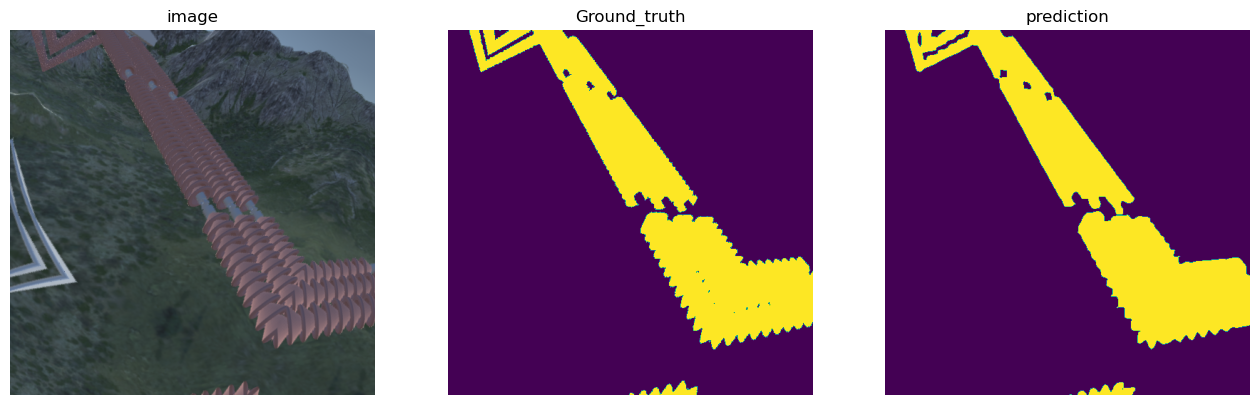

In [22]:
indx = np.random.randint(0, 2)
test_prediction = torch.argmax(y_hat[indx], 0).to('cpu').numpy()
Ground_truth = torch.argmax(y[indx], 0).to('cpu').numpy()
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(16,9))
ax1.imshow(x[indx].to('cpu').numpy().transpose(1,2,0))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(Ground_truth)
ax2.set_title('Ground_truth')
ax2.axis('off')
ax3.imshow(test_prediction)
ax3.set_title("prediction")
ax3.axis('off')


In [23]:

torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/pspnet_resnet50_polymer.pth')

In [24]:
#load model 
model_path =r'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/pspnet_resnet50_polymer.pth'
model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
model.load_state_dict(torch.load(model_path))

C:\Users\User\AppData\Local\Temp\ipykernel_20636\1429510413.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [25]:
model.to('cuda')

PSPNet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [26]:
dir = 'C:/Users/User/Desktop/rakin2/segment/notebook/real_dataset.csv'

In [27]:
transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    # A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    # A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    # A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
], is_check_shapes=False)

In [28]:
real_data = SegmentDataset(dir,2,transform=transform )

In [29]:
real_dataloader = torch.utils.data.DataLoader(real_data, batch_size=10, shuffle=True)

In [30]:
#images, masks = next(iter(real_dataloader))

In [31]:
print(f'sahpe of the image {images.shape} and mask {masks.shape} ,images type {type(images)} and mask type {type(masks)}')

sahpe of the image torch.Size([2, 3, 512, 512]) and mask torch.Size([2, 2, 512, 512]) ,images type <class 'torch.Tensor'> and mask type <class 'torch.Tensor'>


In [32]:
#model.eval()
#real_predictions = []

#with torch.no_grad():
    #for images, masks in tqdm(real_dataloader):
        #images = images.to('cuda')
        #masks = masks.to('cuda')
        #outputs = model(images)
        #preds = torch.argmax(outputs, dim=1)
        #0+.
#real_predictions.append(preds.cpu().numpy())


In [33]:
plt.figure(figsize=(16, 16))

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [34]:
# import matplotlib.pyplot as plt
# random_indx = np.random.randint(0, 1000)
# Select a random index to visualize
# indx = np.random.randint(0, len(images))

# Get the image, ground truth, and prediction
# image = images[indx].to('cpu').numpy().transpose(1, 2, 0)
# ground_truth = torch.argmax(masks[indx], 0).to('cpu').numpy()
# prediction = torch.argmax(outputs[indx], 0).to('cpu').numpy()

# Plot the image, ground truth, and prediction
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
# ax1.imshow(image)
# ax1.set_title('Image')
# ax1.axis('off')
# ax2.imshow(prediction)
# ax2.set_title('Ground Truth')
# ax2.axis('off')
# plt.savefig(f'prediction{random_indx}.png')
# plt.show()